# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 ноября, -4 балла после 06:00 24 ноября, -6 баллов после 06:00 1 декабря, -8 баллов после 06:00 8 декабря.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [458]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [7]:
USER_NAME = u"Турганбаев".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


# Теоретическое введение



*** Что почитать по теории ***

Одна из лучших книг по ML $-$ "Pattern Recognition and Machine Learning" Bishop, Christopher. Логистическая регрессия в ней в параграфе 4.3

Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
где $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал тогда принимает вид:
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту регуляризацию в функцию потерь.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации. Отметим, что вне зависимости от алгоритма оптимизации, данная модель все равно будет называться ***логистической регрессией***.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь c L1-регуляризацией  могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $ \partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для логистической регрессии.
* Посчитайте градиент функции потерь по весам для модели логистической регрессии с конкретно Вашей регуляризацией:

$$ \nabla_w L = \dots $$

 Отнеситесь к этому пункту максимально серьезно, этот градиент Вам нужно будет реализовать в задании.

***Ваше решение здесь***

Считал безхитростно и влоб

$$\nabla _w L = \left(\frac{\partial L}{\partial w_k} \right) = 
    \left(-\frac{1}{N} \left[  
        \sum_{i=1}^D y_i \frac{exp(-\langle x_i,w \rangle - w_0) x_k^{(i)}}{1 + exp(-\langle x_i,w \rangle - w_0)} + 
        (1 - y_i)\left(\frac{exp(-\langle x_i,w \rangle - w_0) x_k^{(i)}}{1 + exp(-\langle x_i,w \rangle - w_0) - x_k^{(i)}} \right)
    \right] + \frac{1}{C} sign(w_k) \right)  = \text{также безхитростно влоб все раскрыл} = 
    \left(\frac{1}{N}  \sum_i x_k^i (a_i - y_i) + \frac{1}{C} sign(w_k) \right)
    $$
$$\quad k=0\dots D  \quad$$

Задача 2. Анализ поведения градиента.

Посчитав формулу градиента, подумайте, как будут меняться веса в зависимости  от "вида" ошибки: 
* Если правильный ответ был  класс "1", а значение $a(x_i)$ близко к нулю, после шага градиентного спуска веса в среднем увеличатся или уменьшатся?



* Если правильный ответ был  класс "0", а значение $a(x_i)$ близко к  единице, после шага градиентного спуска веса в среднем увеличатся или уменьшатся?

Вам такое поведение кажется логичным?


***Ваше решение здесь***

$$
\frac{\partial L}{\partial w_k} = \frac{1}{N} \sum_i x_k^i (a_i - y_i) + \frac{1}{C} sign(w_k)
$$
* Если правильный ответ был  класс "1", а значение $a(x_i)$ близко к нулю, после шага градиентного спуска веса в среднем увеличатся или уменьшатся?

    Если правильный ответ был  класс "1", а значение $a(x_i)$ близко к нулю, то разностные производные будут в "среднем отрицательными". Т.к. градиентый спуск идет в направлении антиградиента, то веса должны "в среднем" увеличиться.

* Если правильный ответ был  класс "0", а значение $a(x_i)$ близко к  единице, после шага градиентного спуска веса в среднем увеличатся или уменьшатся?

    Eсли правильный ответ был  класс "0", а значение $a(x_i)$ близко к единице, то разностные производные будут в "среднем положительными". Т.к. градиентый спуск идет в направлении антиградиента, то веса должны "в среднем" уменьшиться.
    

Да.

Задача 3. Сравнение с линейной регрессией.

Как было рассказано на лекции, функция потерь линейной регрессии без регуляризации имеет вид:
$$ L( w ) = \frac{1}{N}\left[\sum_i (a(x_i) - y_i)^2 \right] $$
где $a(x_i)$ предсказания модели на $i$ объекте, $y_i$ $-$ значение целовой переменной на $i$ объекте, $N$ $-$ размер выборки.
$a(x_i)$ через веса и признаки вычисляется как:
$$ a(x_i) =  \langle\,x_i,w\rangle $$
где $x_i$ $-$ вектор признаков, $w$ $-$ вектор весов модели.
* Посчитайте градиент  функции потерь по весам для модели линейной регрессии:
$$ \nabla_w L = \dots $$
Как соотносится этот градиент с градиентом, возникающий в задаче логистической регресии? Вас это удивило, Вы это уже раньше заметили или Вам все равно? 

***Ваше решение здесь***

$$\nabla _w L = \frac{\partial L}{\partial w_k} = \frac{2}{N} \sum_i x_k^i (a_i - y_i)$$

Меня это удивило. Формулы такие же, но в случае линейной регрессии скалярное произведение, а в случае логистической сигмоида или что-то другое, что считает вероятность.

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

$ p(y_i = 1 | x_i) = p = 1 - p(y_i = 0 | x_i),\  a(x_i) = a $
$$E(L|x_i) = -p \log a - (1 - p) \log(1-a) $$
$$E'_a = -p \frac{1}{a} + \frac{(p - 1)}{1 - a} = \frac{a - p}{a(1 - a)}$$

Отсюда получаем, что при $p = a$ минимум.

#  Реализация логистической регрессии (6 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [194]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    Xy = np.c_[np.ones(y.shape),X,y]
    if shuffle:
        np.random.shuffle(Xy)

    for i in range(batch_size,Xy.shape[0],batch_size):
        X_batch = Xy[i - batch_size:i,:-1]
        y_batch = Xy[i - batch_size:i,-1]
        yield (X_batch, y_batch)
        if i + batch_size >= Xy.shape[0]:
            yield (Xy[i:,:-1], Xy[i:,-1])

# Теперь можно сделать генератор по данным ()
# my_batch_generator = batch_generator(X_train, y_train, shuffle=True, batch_size=10)

In [500]:
#%%pycodestyle
from sklearn.base import BaseEstimator, ClassifierMixin


def sigmoid(X):
    """
    Вычисляем значение сигмоида.
    X - матрица объекты-признаки
    """
    # Your code Here
    return 1 / (1 + np.exp(-X))


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, batch_generator, C=1, alpha=0.01,
                 max_epoch=10, batch_size=10):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.batch_size = batch_size
        self.errors_log = {'iter': [], 'loss': []}

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """
        eps = np.finfo(np.float32).eps
        tmp = sigmoid(np.dot(X_batch, self.weights))
        sum1 = np.log(tmp + eps) * y_batch
        sum2 = (1 - y_batch) * np.log(1 - tmp + eps)
        sum_ = np.sum(sum1 + sum2) / X_batch.shape[0]
        loss = sum_ + np.sum(np.abs(self.weights)) / self.C
        return -loss

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу
            (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        """
        pred_test_diff = sigmoid(np.dot(X_batch, self.weights)) - y_batch
        loss_grad = np.dot(X_batch.T, pred_test_diff) / X_batch.shape[0]
        return loss_grad

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= new_grad * self.alpha
        self.weights = np.where(self.weights > 0,
                                np.maximum(
                                    np.zeros(self.weights.shape),
                                    self.weights - self.alpha / self.C
                                ),
                                self.weights)
        self.weights = np.where(self.weights < 0,
                                np.minimum(
                                    np.zeros(self.weights.shape),
                                    self.weights + self.alpha / self.C
                                ),
                                self.weights)

    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''

        # Нужно инициализровать случайно веса
        self.weights = np.random.random(X.shape[1] + 1)
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_loss = self.calc_loss(X_batch, y_batch)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать
                # ошибку для отладки модели
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        '''

        # Желательно здесь использовать матричные операции между X и весами,
        # например, numpy.dot
        y_hat_proba = self.predict_proba(X)
        N = X.shape[0]
        y_hat = np.where(y_hat_proba > 0.5, np.zeros(N) + 1, np.zeros(N) - 1)
        return y_hat

    def predict_proba(self, X):
        '''
        Предсказание вероятности положительного класса
        X - матрица объекты-признаки
        '''

        # Желательно здесь использовать матричные операции
        # между X и весами, например, numpy.dot
        X_ = np.c_[np.ones(X.shape[0]), X]
        y_hat_proba = np.dot(X_, self.weights)
        return y_hat_proba


Запустите ваш алгоритм на синтетических данных. 

Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [506]:
#%%pycodestyle
def plot_decision_boundary(clf, X):
    # Your code Here
    w_0, w_1, w_2 = cls.weights
    x = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    y = -(w_0 + w_1 * x) / w_2
    plt.plot(x, y)

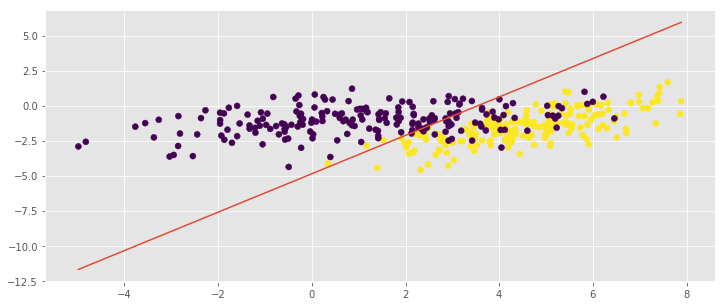

In [509]:
#%%pycodestyle
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

cls = MySGDClassifier(batch_generator, C=100, batch_size=10)
cls.fit(X, y)
plot_decision_boundary(cls, X)

plt.scatter(X[:, 0], X[:, 1], c=y)


Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [363]:
from sklearn.datasets import make_classification

In [442]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

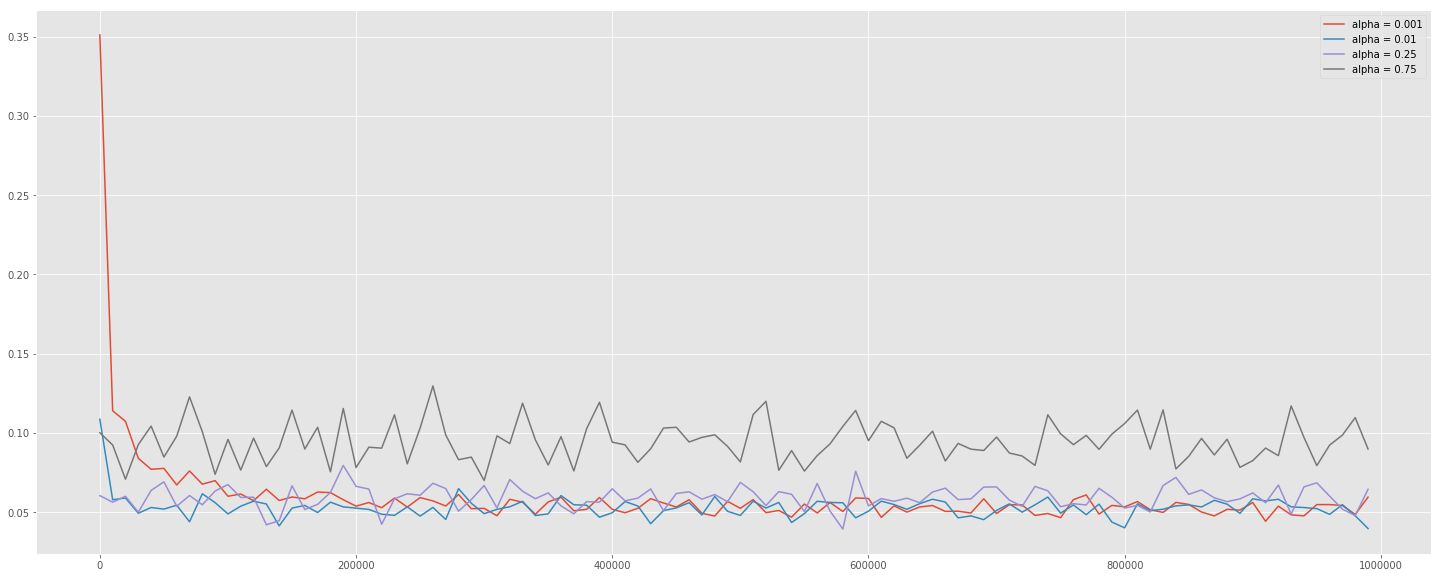

In [443]:
## Your Code Here
alphas = [0.001, 0.01, 0.25, 0.75]
fig = plt.figure(figsize=(25, 10))
epochs = 10
C = 1000
N = 100
batch_size = 10000
for alpha in alphas:
    my_cls = MySGDClassifier(batch_generator, C, alpha, epochs, batch_size)
    my_cls.fit(X, y)
    means = np.mean(np.array_split(my_cls.errors_log['loss'], N),axis=1)
    iters = np.array(np.array_split(np.arange(len(my_cls.errors_log['iter'])), N))[:,0]
    plt.plot(iters, means, label=f'alpha = {alpha}')
plt.legend()
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Чем больше шаг, тем быстрее сходимость, но чем меньше шаг, тем меньше скачки. Отсюда следует, что лучше с каждой итерацией уменьшать шаг.

Изобразите график среднего значения весов модели в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

[1.00000000e+03 2.15443469e+02 4.64158883e+01 1.00000000e+01
 2.15443469e+00 4.64158883e-01 1.00000000e-01 2.15443469e-02
 4.64158883e-03 1.00000000e-03]
[ 2.46950800e+00 -1.35843608e-01  5.21648128e-02 -4.19721262e-02
 -2.27961511e+00 -1.33783318e+00  2.18424968e+00  9.23664351e-02
 -1.77660190e+00 -1.97738528e-02  8.09338895e-04]
[ 1.74306213e+00  1.03022928e-02  9.24902697e-03 -3.19507223e-02
 -2.03397980e+00 -9.23869851e-01  2.03076163e+00  1.61051870e-02
 -1.11303925e+00  2.93070694e-04 -7.31599931e-03]
[ 3.24240981e-01 -2.94849300e-03 -5.02485871e-03  7.69262954e-03
 -1.54971159e+00 -1.88743054e-01  1.62851329e+00  1.32932543e-04
 -2.64532345e-02  0.00000000e+00 -1.45333689e-02]
[ 5.30565588e-03  6.43294699e-04  5.27496975e-03 -1.05388645e-02
 -8.77791500e-01 -1.67189611e-01  8.63226584e-01  8.00649515e-03
 -2.44436479e-03 -5.56298155e-03  3.54847606e-03]
[ 0.          0.00103016  0.          0.00568915 -0.03205605 -0.1023917
  0.02414165  0.         -0.00451613 -0.00278947 -0.00

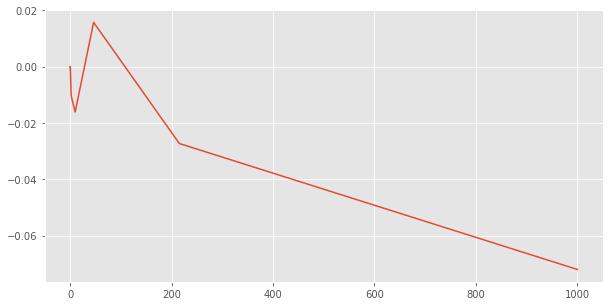

In [446]:
## Your Code Here
cc = np.logspace(3, -3, 10)
print(cc)
means = []

for i, c in enumerate(cc):
    cls = MySGDClassifier(batch_generator, C=c, batch_size=10000)
    cls.fit(X, y)
    means.append(cls.weights.mean())
    print(cls.weights)


fig = plt.figure(figsize=(10, 5))
plt.plot(cc, means)
plt.show()



Довольны ли Вы, насколько сильно уменьшились Ваши веса? Если нет, то как можно было бы уменьшать их еще сильнее?

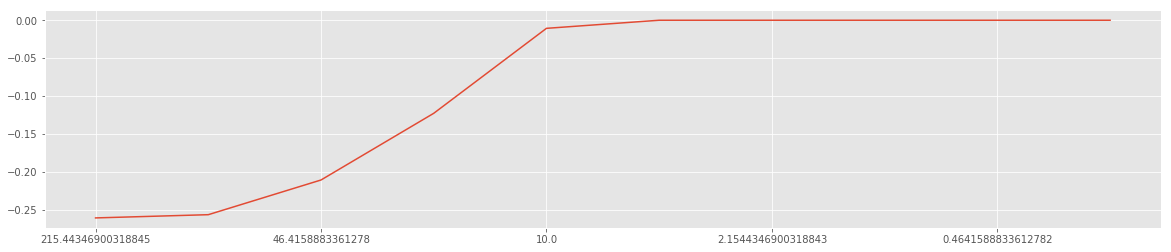

In [457]:
fig = plt.figure(figsize=(20,4))


plt.plot(np.arange(len(cc)), means)
ax = plt.gca()
ax.set_xticklabels(cc)
plt.show()

Теперь хорошо видно, что чем, меньше C, тем меньше будут веса.

# Боевое применение (2  балла)

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная онлайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

In [510]:
# Загрузка данных для обучения
filepath = 'trainingData_tabular/trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [511]:
df_data.head()

,gamestate_id,decision,turn,opponent.armor,opponent.attack,opponent.hero_card_id,opponent.hp,opponent.special_skill_used,opponent.weapon_durability,opponent.crystals_all,...,player.played.hp_current,player.played.hp_max,player.hand.nOfMinions,player.hand.nOfSpells,player.hand.nOfWeapons,player.hand.nOfCards,player.hand.nOfPlayable,player.hand.attack,player.hand.crystals_cost,player.hand.hp
0,4687346,1,14,0,0,798,5,0,0,10,...,20,23,4,0,1,5,0,20,22,17
1,3270826,1,7,0,0,754,22,0,0,6,...,16,17,3,2,2,7,0,17,26,20
2,3189487,1,5,3,0,612,29,0,0,4,...,0,0,5,0,0,5,2,26,28,27
3,4098946,1,8,0,0,390,26,0,0,7,...,2,2,7,1,1,9,9,36,44,36
4,2661127,0,13,0,0,25,30,0,0,10,...,7,7,4,0,0,4,4,13,13,14


In [512]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [513]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [514]:
# Распределение классов
df_data.decision.mean()
# Примерно поровну

0.504702

## Обучение модели

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы. (Вы точно понимаете, зачем это нужно сделать? Если нет, спросите обязательно преподавателя!)
* Стандартизируйте признаки с помощью `StandartScaller` из sklearn (Вы точно понимаете, зачем это нужно сделать? Если нет, спросите обязательно преподавателя!)
* Обучите модель, подбирая параметры на отложенном контроле

In [515]:
## Youd Code Here
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [516]:
df_data = pd.get_dummies(df_data, columns=
                    ['opponent_special_skill_used', 'player_special_skill_used'])
y = df_data['decision'].values
X = df_data.drop(['decision'], axis = 1)

In [517]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [518]:
param_grid = {'alpha':[0.001,0.01],
         'C': [100, 1000, 10000],
         'batch_size' : [10000, 50000]}
model = MySGDClassifier(batch_generator)
grid_search = GridSearchCV(model, param_grid=param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=MySGDClassifier(C=1, alpha=0.01,
        batch_generator=<function batch_generator at 0x7f1bcaf2eae8>,
        batch_size=10, max_epoch=10),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.01], 'C': [100, 1000, 10000], 'batch_size': [10000, 50000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [521]:
cls = grid_search.best_estimator_

In [523]:
cls

MySGDClassifier(C=10000, alpha=0.01,
        batch_generator=<function batch_generator at 0x7f1bcaf2eae8>,
        batch_size=50000, max_epoch=10)

## Применение модели 
* Подготовьте тестовые данные  к подаче на вход в алгоритму (нужно сделать такие же преобразования, как при обучении)
* Примените модель оцените качество на тесте с помощью меры ROC-AUC (имплментацию взять из sklern.metrics)


In [524]:
# Загрузка данных для тестирования
filepath_test = 'trainingData_tabular/trainingData_tabular_chunk2.csv'
df_data_test = pd.read_csv(filepath_test, sep=',')

In [ ]:
## Youd Code Here
def prepare_test(df_data):
    df = df_data
    df.columns = df.columns.str.replace('.', '_')
    df = df.set_index('gamestate_id')
    df = pd.get_dummies(df, columns=
                        ['opponent_special_skill_used', 'player_special_skill_used'])
    y = df['decision'].values
    X = df.drop(['decision'], axis = 1)
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X, y
    
X, y = prepare_test(df_data_test)

In [ ]:
roc_auc_score(y, cls.predict(X))

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему линейных моделей и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите основные, на Ваш взгляд,  отличия логистической регрессии от линейной регрессии. Почему, на ваш взгляд, задачу классификации решают логистической, а не линейной регрессией?

***Ваше ответ здесь***

Одно задача классицикации, другое задача регресии.

Возможно потомучто ответ похож на булеву переменную.

* Как Вы думаете, для каких типов задач (объем данных, число признаков, типы признаков) стоит отдавать предпочтение линейным моделям?

***Ваше ответ здесь***

Если много числовых признаков, то лучше линейную модель.
Если объем большой, то не стоит т.к. долго.
Если признаки зависимы друг от друга, то тоже не стоит.

* Пусть на обучении мы имеем выборку размера $N$, число признаков $D$. Чему равна алгоритмическая сложность одного шага градиентного спуска? Cтохастического градиентного спуска?  Сложность предсказания на одном объекте?

***Ваше ответ здесь***
Сложность шага соответсвутет сложности пересчета градиента
$$O(ND^2) - \text{расчет градиента в обычном случае}$$
$$O(D^2) * O(1) - \text{расчет градиента в случае стохастического градиентного спуска},\ O(1) - \text{размер батча}$$


на 1 объекте выходит одинакого. 

* В чем преимущества стохастического градиентного спуска (в том числе мини-батч) над обычным градиентным спуском? В чем его недостатки? Рассмотрите несколько аспектов $-$ скорость сходимости, необходимость загрузки всех данных в оперативную память, сложность вычисления одного шага.

***Ваше ответ здесь***

1. Быстрее т.к. при расчете градиенте не вся выборка используется.
2. По памяти выгоднее выходит, из дз это видно.
3. Во время обучения тестовые данные могут расти, можем непрерывно обучаться.

Недостакток в том, что точность ниже т.к. используется не вся выборка.

* Как Вы думаете, при обучении линейной модели с помощью SGD, ошибку на новом объекте стоит считать до итерации спуска на этом объекте или после? Почему Вы так думаете? Возможно, Вам будет интересно ознакомиться с http://hunch.net/~jl/projects/prediction_bounds/thesis/mathml/thesisse44.xml

***Ваше ответ здесь***

Думаю до, т.к. после она обучится на ней.

* Как Вы думаете, во времена такого бума нейронных сетей, остаются ли популярными линейные модели, или это уже пережиток прошлого? Почему Вы так думаете?

***Ваше ответ здесь***

Остаются популярными.
Они надежные, понятно как работают. Если есть линейная зависимость между признаками и данные хорошо разделимы, то результат хороший.


* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

Мало математики. Хочется посидеть поразбираться с теорией. Хочется больше задачек на математику, чтобы суть понимать.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

Понравилось, что есть часть с математикой.

Больше выкладок, подробнее.
Лучше больше математики, но меньше кода.
Ноутбуки лекций слишком тезисные.